# BM3D Rust Verification & Benchmarking

This notebook verifies the new Rust-backend implementation of BM3DORNL. 
It covers:
1.  **Synthetic Benchmark**: Performance testing on generated noise.
2.  **Real Data Comparison**: Comparing 'Generic' BM3D vs 'Streak Removal' mode for ring artifact reduction.

**Note**: This notebook uses the updated `bm3dornl` package with colored noise support.

In [3]:
# %% Configuration
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from bm3dornl.bm3d import bm3d_ring_artifact_removal
from bm3dornl import svdmg

# Common parameters (same for both methods)
CONFIG = {
    'mode': 'streak',           # Required for multiscale
    'sigma_random': 0.0,        # Default
    'patch_size': 8,            # Default
    'step_size': 4,             # Default
    'search_window': 24,        # Default
    'max_matches': 16,          # Default (note: not 32 as in single-pass notebook)
    'batch_size': 32,           # Default
    'threshold': 2.7,           # Default
    'streak_sigma_smooth': 3.0, # Default
    'streak_iterations': 1,     # Default
    'sigma_map_smoothing': 20.0,# Default
    'streak_sigma_scale': 1.1,  # Default
    'psd_width': 0.6,           # Default
}

# Multi-scale specific (use defaults)
MULTISCALE_CONFIG = {
    'num_scales': None,         # Auto-detect
    'filter_strength': 1.0,     # Default
    'debin_iterations': 30,     # Default
}

# %% Data paths and slices
DATA_PATH = "../tests/bm3dornl-data/tomostack_small.h5"
SLICE_LOW_SNR = 10      # Edge of sample
SLICE_HIGH_SNR = 250    # Middle of sample

# %% Load data
with h5py.File(DATA_PATH, 'r') as f:
    noisy_stack = f['noisy_tomostack'][:]
    clean_stack = f['clean_tomostack'][:]

print(f"Stack shape: {noisy_stack.shape} = (angles, y, x)")

# Extract sinograms (axis 1 = y)
sino_low_noisy = noisy_stack[:, SLICE_LOW_SNR, :]
sino_low_ref = clean_stack[:, SLICE_LOW_SNR, :]
sino_high_noisy = noisy_stack[:, SLICE_HIGH_SNR, :]
sino_high_ref = clean_stack[:, SLICE_HIGH_SNR, :]

print(f"Sinogram shape: {sino_low_noisy.shape} = (angles, x)")

# %% Process function with timing
def process_sinogram(sino, multiscale=False):
    """Process sinogram and return result with timing."""
    t0 = time.time()
    result = bm3d_ring_artifact_removal(
        sino,
        **CONFIG,
        multiscale=multiscale,
        **(MULTISCALE_CONFIG if multiscale else {})
    )
    elapsed = time.time() - t0
    return result, elapsed

def process_svd(sino):
    """Process sinogram with SVD-MG and return result with timing."""
    t0 = time.time()
    # Note: svd_streak_removal expects float32 and returns float32
    result = svdmg.svd_streak_removal(sino)
    elapsed = time.time() - t0
    return result, elapsed

# %% Process all
print("Processing low SNR slice...")
sino_low_single, time_low_single = process_sinogram(sino_low_noisy, multiscale=False)
sino_low_multi, time_low_multi = process_sinogram(sino_low_noisy, multiscale=True)
sino_low_svd, time_low_svd = process_svd(sino_low_noisy)

print("Processing high SNR slice...")
sino_high_single, time_high_single = process_sinogram(sino_high_noisy, multiscale=False)
sino_high_multi, time_high_multi = process_sinogram(sino_high_noisy, multiscale=True)
sino_high_svd, time_high_svd = process_svd(sino_high_noisy)

print("\nTiming Summary:")
print(f"  Low SNR  - Single: {time_low_single:.2f}s, Multi: {time_low_multi:.2f}s, SVD: {time_low_svd:.2f}s")
print(f"  High SNR - Single: {time_high_single:.2f}s, Multi: {time_high_multi:.2f}s, SVD: {time_high_svd:.2f}s")
print(f"  Speedup SVD vs Single: {time_low_single / time_low_svd:.2f}x")


Stack shape: (591, 540, 620) = (angles, y, x)
Sinogram shape: (591, 620) = (angles, x)
Processing low SNR slice...
Processing high SNR slice...

Timing Summary:
  Low SNR  - Single: 0.19s, Multi: 0.29s, SVD: 0.01s
  High SNR - Single: 0.19s, Multi: 0.29s, SVD: 0.01s
  Speedup SVD vs Single: 34.05x


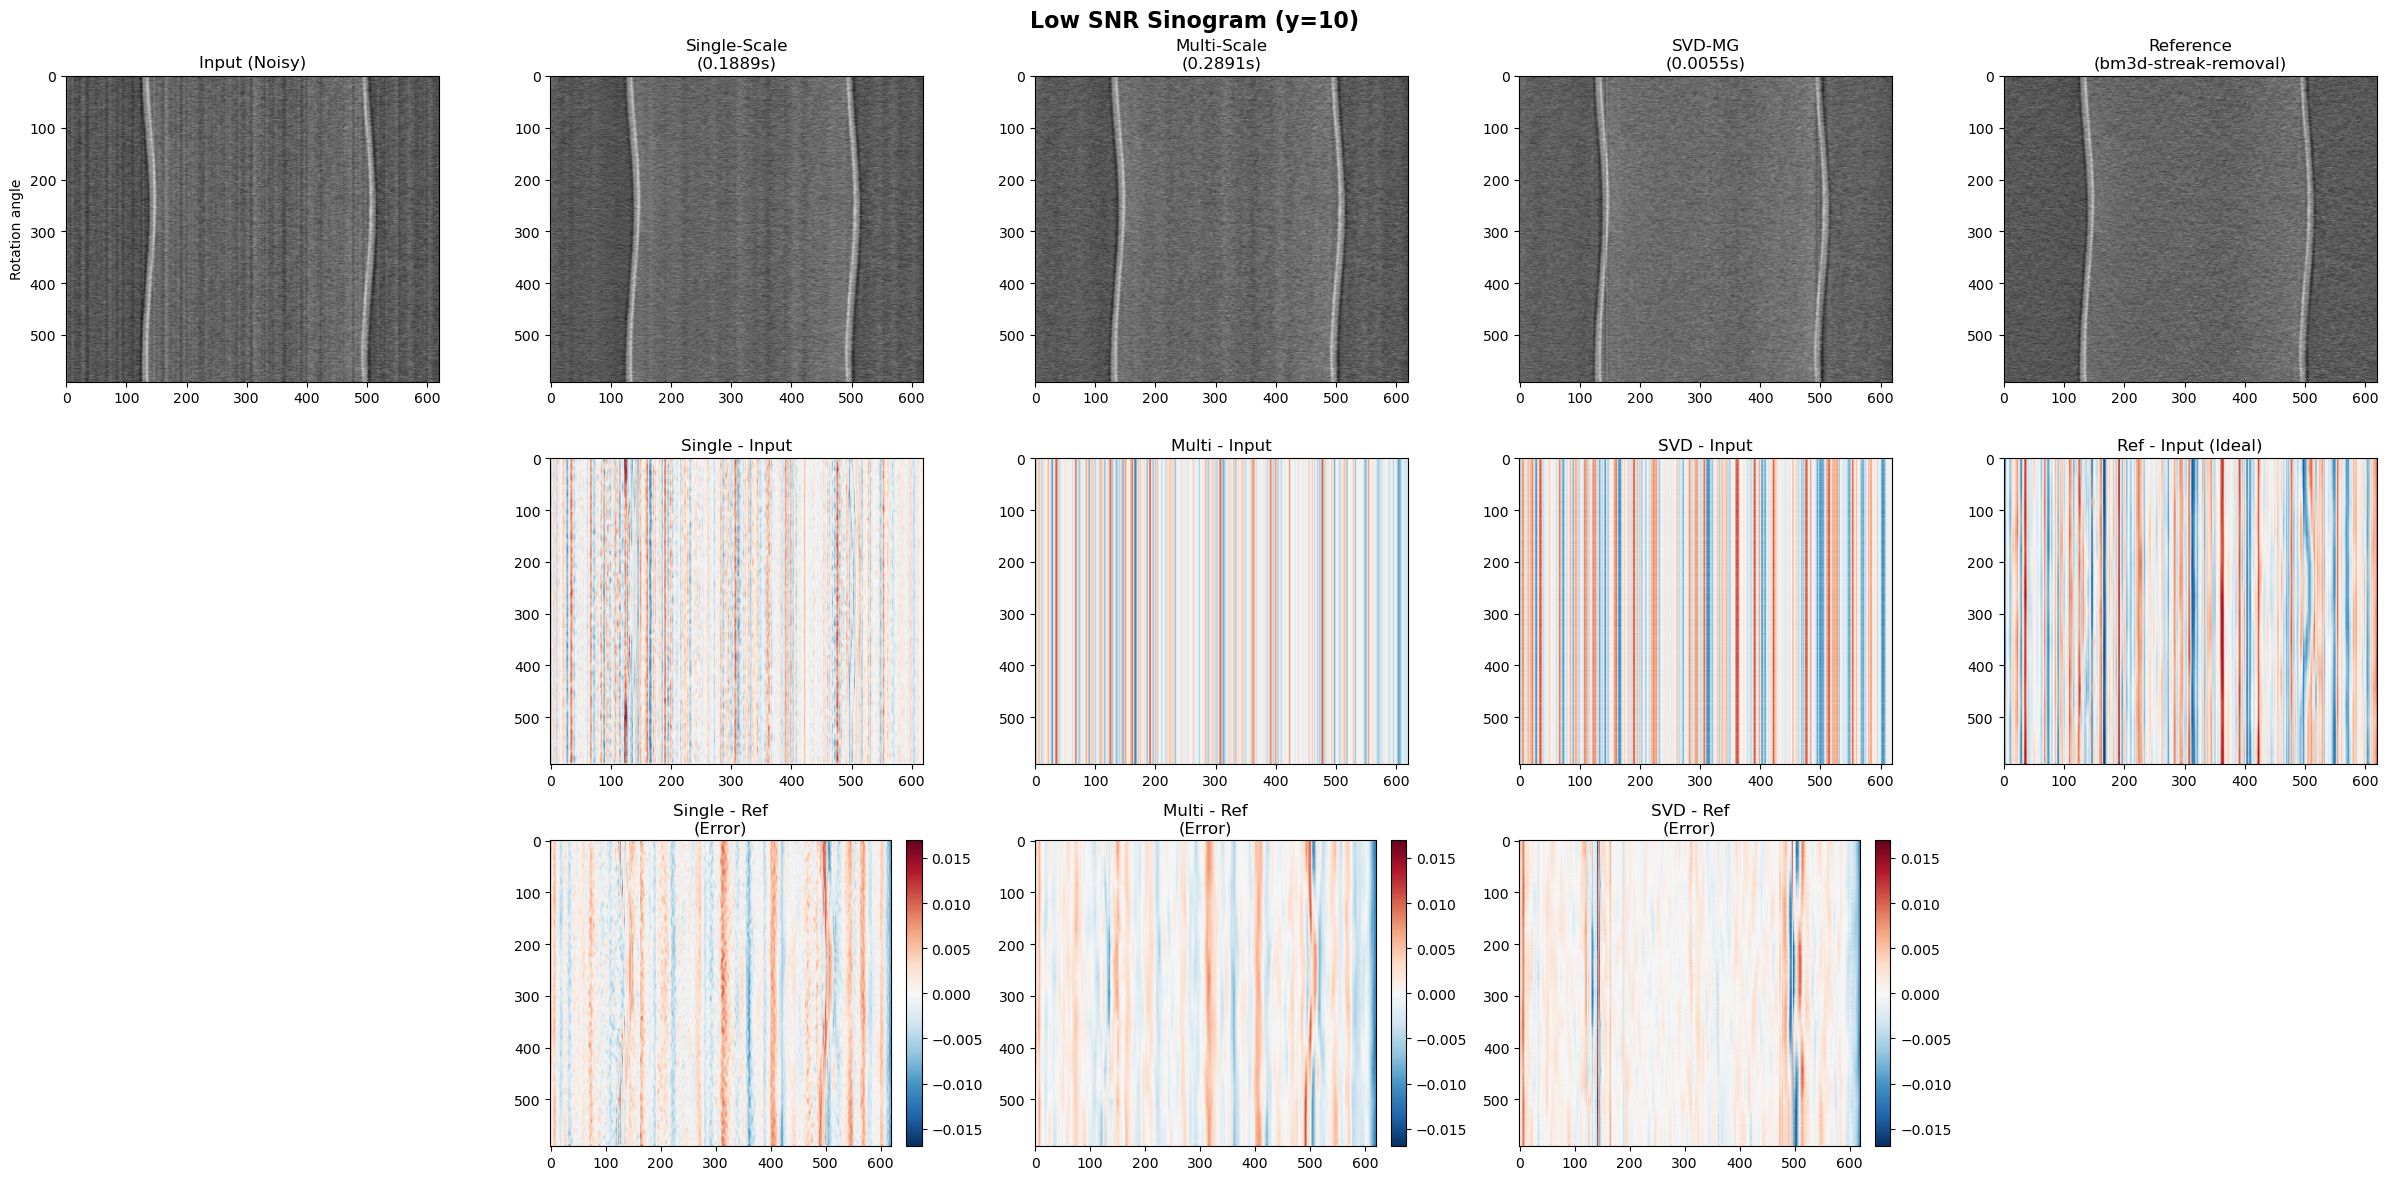


Low SNR Sinogram (y=10) - Metrics (vs Reference)
Metric                        Single           Multi          SVD-MG
--------------------------------------------------------------------------------
MAE                         0.002409        0.002065        0.001681
Time (s)                      0.1889          0.2891          0.0055
Speedup vs Single               1.0x            0.65x           34.05x


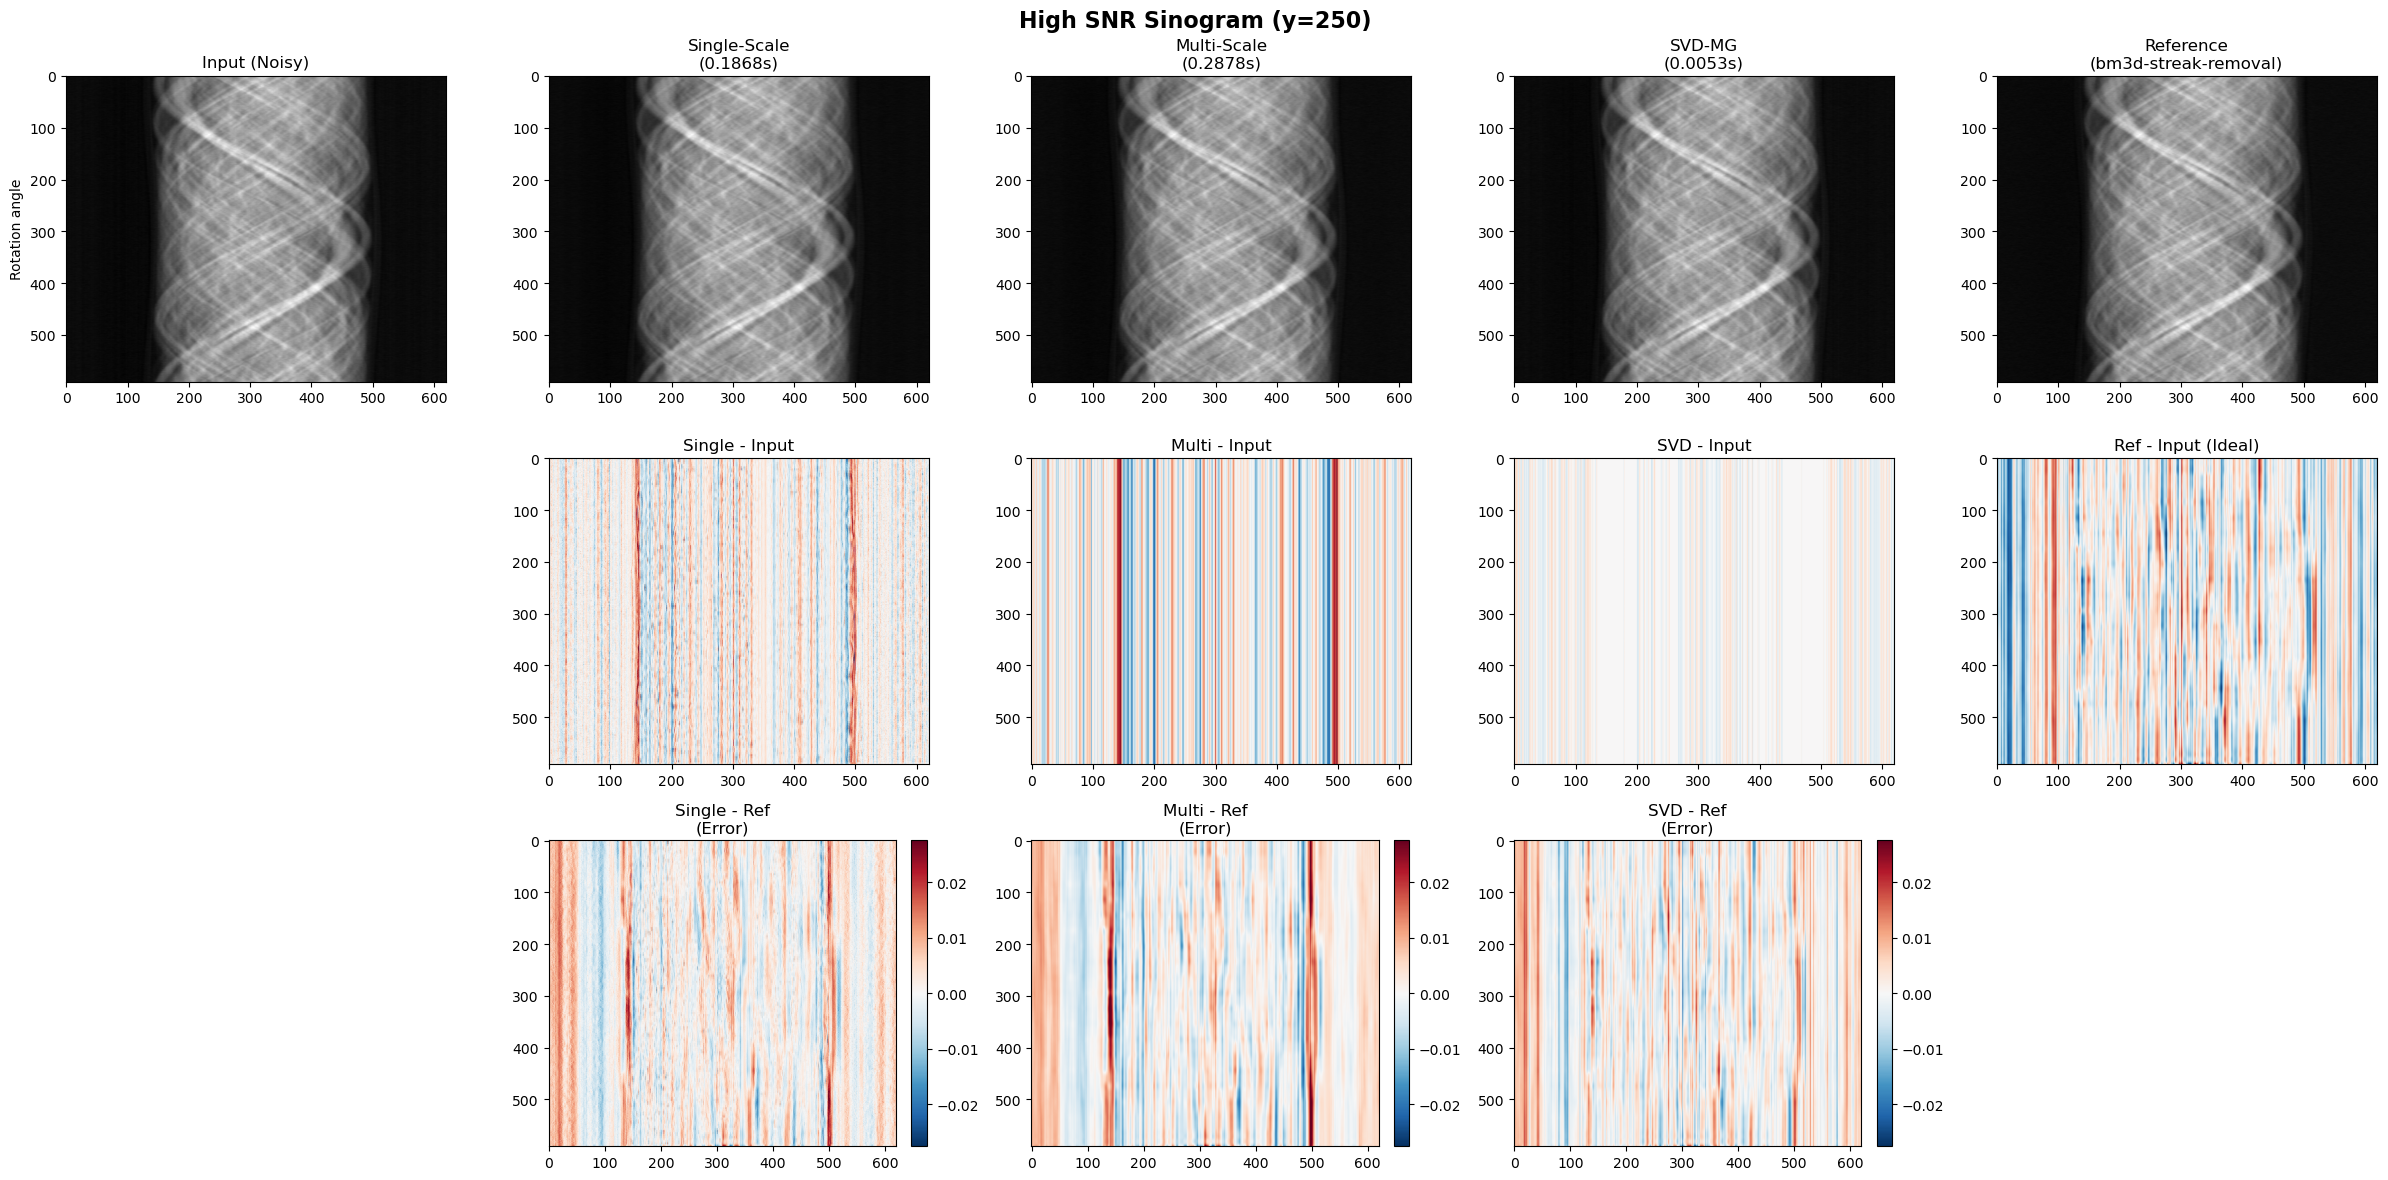


High SNR Sinogram (y=250) - Metrics (vs Reference)
Metric                        Single           Multi          SVD-MG
--------------------------------------------------------------------------------
MAE                         0.004623        0.004827        0.004441
Time (s)                      0.1868          0.2878          0.0053
Speedup vs Single               1.0x            0.65x           35.09x


In [4]:
# %% Evaluation Function - Difference from Reference
def evaluate_streak_removal(noisy, single, multi, svd, ref, 
                            time_single=None, time_multi=None, time_svd=None,
                            title_prefix=""):
    """
    Display comprehensive comparison of streak removal methods including SVD-MG.
    
    Row 1: Input | Single | Multi | SVD | Ref
    Row 2: What was removed (Image - Noisy)
    Row 3: Error vs Reference (Image - Ref)
    """
    
    fig, axes = plt.subplots(3, 5, figsize=(24, 12))  # Wider for 5 columns
    
    # Determine common scale for difference images
    vmax_removal = max(
        np.abs(single - noisy).max(),
        np.abs(multi - noisy).max(),
        np.abs(svd - noisy).max(),
        np.abs(ref - noisy).max()
    ) * 0.8
    
    vmax_error = max(
        np.abs(single - ref).max(),
        np.abs(multi - ref).max(),
        np.abs(svd - ref).max()
    ) * 0.8
    
    # --- Row 1: Raw Images ---
    # Input
    axes[0, 0].imshow(noisy, aspect='auto', cmap='gray')
    axes[0, 0].set_title('Input (Noisy)')
    axes[0, 0].set_ylabel('Rotation angle')
    
    # Single
    axes[0, 1].imshow(single, aspect='auto', cmap='gray')
    axes[0, 1].set_title(f'Single-Scale\n({time_single:.4f}s)' if time_single else 'Single-Scale')
    
    # Multi
    axes[0, 2].imshow(multi, aspect='auto', cmap='gray')
    axes[0, 2].set_title(f'Multi-Scale\n({time_multi:.4f}s)' if time_multi else 'Multi-Scale')
    
    # SVD
    axes[0, 3].imshow(svd, aspect='auto', cmap='gray')
    axes[0, 3].set_title(f'SVD-MG\n({time_svd:.4f}s)' if time_svd else 'SVD-MG')
    
    # Ref
    axes[0, 4].imshow(ref, aspect='auto', cmap='gray')
    axes[0, 4].set_title('Reference\n(bm3d-streak-removal)')
    
    # --- Row 2: Removed Content (Result - Input) ---
    axes[1, 0].axis('off')
    
    # Single diff
    im1 = axes[1, 1].imshow(single - noisy, aspect='auto', cmap='RdBu_r',
                            vmin=-vmax_removal, vmax=vmax_removal)
    axes[1, 1].set_title('Single - Input')
    
    # Multi diff
    im2 = axes[1, 2].imshow(multi - noisy, aspect='auto', cmap='RdBu_r',
                            vmin=-vmax_removal, vmax=vmax_removal)
    axes[1, 2].set_title('Multi - Input')
    
    # SVD diff
    im_svd = axes[1, 3].imshow(svd - noisy, aspect='auto', cmap='RdBu_r',
                               vmin=-vmax_removal, vmax=vmax_removal)
    axes[1, 3].set_title('SVD - Input')
    
    # Ref diff
    im3 = axes[1, 4].imshow(ref - noisy, aspect='auto', cmap='RdBu_r',
                            vmin=-vmax_removal, vmax=vmax_removal)
    axes[1, 4].set_title('Ref - Input (Ideal)')
    
    # --- Row 3: Error vs Reference (Result - Ref) ---
    axes[2, 0].axis('off')
    
    # Single error
    im4 = axes[2, 1].imshow(single - ref, aspect='auto', cmap='RdBu_r',
                            vmin=-vmax_error, vmax=vmax_error)
    axes[2, 1].set_title('Single - Ref\n(Error)')
    plt.colorbar(im4, ax=axes[2, 1], fraction=0.046, pad=0.04)
    
    # Multi error
    im5 = axes[2, 2].imshow(multi - ref, aspect='auto', cmap='RdBu_r',
                            vmin=-vmax_error, vmax=vmax_error)
    axes[2, 2].set_title('Multi - Ref\n(Error)')
    plt.colorbar(im5, ax=axes[2, 2], fraction=0.046, pad=0.04)
    
    # SVD error
    im6 = axes[2, 3].imshow(svd - ref, aspect='auto', cmap='RdBu_r',
                            vmin=-vmax_error, vmax=vmax_error)
    axes[2, 3].set_title('SVD - Ref\n(Error)')
    plt.colorbar(im6, ax=axes[2, 3], fraction=0.046, pad=0.04)
    
    axes[2, 4].axis('off')
    
    plt.suptitle(f'{title_prefix}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # === Metrics ===
    single_mae = np.abs(single - ref).mean()
    multi_mae = np.abs(multi - ref).mean()
    svd_mae = np.abs(svd - ref).mean()
    
    print(f"\n{title_prefix} - Metrics (vs Reference)")
    print("=" * 80)
    print(f"{'Metric':<20} {'Single':>15} {'Multi':>15} {'SVD-MG':>15}")
    print("-" * 80)
    print(f"{'MAE':<20} {single_mae:>15.6f} {multi_mae:>15.6f} {svd_mae:>15.6f}")
    if time_single:
        print(f"{'Time (s)':<20} {time_single:>15.4f} {time_multi:>15.4f} {time_svd:>15.4f}")
        print(f"{'Speedup vs Single':<20} {'1.0x':>15} {time_single/time_multi:>15.2f}x {time_single/time_svd:>15.2f}x")
    print("=" * 80)

# %% Evaluate Low SNR
evaluate_streak_removal(
    sino_low_noisy, sino_low_single, sino_low_multi, sino_low_svd, sino_low_ref,
    time_single=time_low_single, time_multi=time_low_multi, time_svd=time_low_svd,
    title_prefix=f"Low SNR Sinogram (y={SLICE_LOW_SNR})"
)

# %% Evaluate High SNR
evaluate_streak_removal(
    sino_high_noisy, sino_high_single, sino_high_multi, sino_high_svd, sino_high_ref,
    time_single=time_high_single, time_multi=time_high_multi, time_svd=time_high_svd,
    title_prefix=f"High SNR Sinogram (y={SLICE_HIGH_SNR})"
)
